# NYC Climate Change
### A Brief Analysis of Temperature Changes and Extreme Weather Events in NYC

This independent study analyzes daily temperature data for NYC over a over 150+ year period (1870-2023) to assess whether daily temperatures have been changing over time. This study has been motivated by the World Meteorological Organization's (WMO) briefing on the [Provisional State of the Global Climate in 2022](https://public.wmo.int/en/our-mandate/climate/wmo-statement-state-of-global-climate) and by this [NYTimes article](https://www.nytimes.com/interactive/2018/05/03/learning/08WGOITGraphLN.html). The NYTimes article is in turn based on [this paper](https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109) by Dr. Hansen et al., and many of the research techniques within this project are guided by the methods used in the paper. However, while the article focuses on summer temperature changes, this project focuses on temperature changes year round.

The data for this study has been obtained from the National Oceanic and Atmospheric Administration (NOAA) website [here](https://www.ncei.noaa.gov/cdo-web/). The dataset contains over 150 years of daily temperature data (Jan 1,1870 - Dec 31, 2023) from between 1-32 weather stations that NOAA utilizes for New York City temperature readings. 

<!-- ![Outliers.png](attachment:Outliers.png) -->

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### <center> Initial Data Processing</center>

Each record is a reading from a particular weather station for a given day. These have been aggregated by using the median values across all stations to calculate a median observed temperature for that day. Note that median has been used instead of a simple average as it is more robust to outliers. Separately, the maximum and minimum observed temperature for each day (across any station) is also retained; this is used later for outlier analysis.

In [2]:
dfraw = pd.DataFrame()
for file in os.listdir("raw_data"):
    _ = pd.read_csv("raw_data/"+file, parse_dates = [2])
    dfraw = pd.concat([dfraw, _], axis = 0)

##dropping duplicates (none)
# dfraw.drop_duplicates(inplace = True)

#dropping 'TAVG' and 'TOBS' since >75% values are missing
# dfraw.isna().sum()/dfraw.shape[0]
dfraw.drop(['TAVG','TOBS'], axis = 1, inplace = True)

print(f"The source data contains {dfraw.shape[0]} observations from {datetime.strftime(dfraw.DATE.min(), '%d %b, %Y')} to {datetime.strftime(dfraw.DATE.max(), '%d %b, %Y')}, covering {dfraw.NAME.nunique()} stations over NYC")
dfraw.sample(5)

The source data contains 245565 observations from 01 Jan, 1870 to 31 Dec, 2023, covering 32 stations over NYC


,STATION,NAME,DATE,TMAX,TMIN
45204,USC00305816,"WORLD TRADE CENTER, NY US",1913-10-08,67.0,62.0
48004,USC00305816,"WORLD TRADE CENTER, NY US",1921-06-08,72.0,59.0
70306,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2014-05-02,69.0,52.0
100,USC00302868,"FLUSHING, NY US",1916-05-11,80.0,52.0
44106,USW00014732,"LAGUARDIA AIRPORT, NY US",2015-11-06,75.0,65.0


In [3]:
#generating a daily estimates for TMAX and TMIN by aggregating daily weather data from each station
df = dfraw.groupby("DATE").agg(Median_TMAX = ("TMAX", np.nanmedian),
                               Median_TMIN = ("TMIN", np.nanmedian),
                               Record_TMAX = ("TMAX", np.max),
                               Record_TMIN = ("TMIN", np.min))
df["Observed_T"] =  np.nanmedian(df[["Median_TMAX","Median_TMIN"]], axis = 1).round(2)
df.drop(["Median_TMAX", "Median_TMIN"], axis = 1, inplace= True)

##Note that since the Paris Accord refers to temperature changes in Celsius, temperature is shown in Celsius in all further analysis
df = (df.apply(lambda x: (x-32)*5/9, axis = 0).round(2)).reset_index()   ##Faehrenheit to Celsius

df["MM-DD"] = df["DATE"].apply(lambda x: x.strftime("%m-%d"))
df["YYYY"] = df["DATE"].apply(lambda x:x.year)

df[["DATE", "Observed_T"]].sample(3)

,DATE,Observed_T
18367,1920-04-16,10.28
24616,1937-05-26,20.83
55919,2023-02-07,2.36


### <center> Comparison Period vs Baseline Period - Analysis of Daily Temperature Differences</center>

In order to analyze temperature changes, daily observed temperatures are compared to a baseline expected daily temperatures. The Paris Climate Accord uses the pre-industrial period of 1850-1900 as its baseline per [here](https://unfccc.int/process-and-meetings/the-paris-agreement) and [here](https://www.ipcc.ch/sr15/faq/faq-chapter-1/). However, the earliest preindustrial data available for Manhattan is from 1870. Therefore <b>the baseline period for this study is defined from 1870 to 1903</b>. While this is shorter than the 50 year period utilized in the Paris Climate Accord, generally, a 30year or longer period would suffice as the baseline periodas it is sufficiently long for meaningful statistical analysis, as explained in [this guidance](https://www.ncei.noaa.gov/access/monitoring/dyk/anomalies-vs-temperature) from NOAA.

The baseline or "expected" temperature for a particular day is calculated as the median of the observed temperatures on that day for each year in the baseline period. For example, the June 1 baseline expected temperature would be calculated as, the median of the June 1 temperatures seen for every year between 1870 through 1903 (the baseline period). This process is repeated for each day and in this way we will have 366 expected temperatures, one for each day of the year.

<b>The comparison dataset for this study is from 1904 through 2023</b>. The daily temperature for each day in the comparison period are compared to the baseline temperature for that day. For example, the June 1 2022 observed temperature (Observed_T) is compared to the June 1 baseline expected temperature (Expected_T). The distribution of the differences in the observed and expected values is then analyzed; if there has not been a material change in temperatures over the years, the expectation is that these differences should be close to zero.

In [4]:
def create_baseline(base_df):
    
    baseline = base_df.groupby("MM-DD").agg(Expected_T = ("Observed_T", np.median),       ##avg. daily baseline temp.
                                  Base_RecordMax = ("Record_TMAX",np.max),   ##max of the max in the baseline period
                                  Base_RecordMin = ("Record_TMIN",np.min)
                                 ).round(2).reset_index()
    return baseline


def temperature_differences(df, baseline, base = "Y"):  
    df = df.merge(baseline, left_on ="MM-DD", right_on = "MM-DD", how = "left")
    df["Diff"] = df["Observed_T"] - df["Expected_T"]

    if base == "N":
        ##adding decade information
        years = list(np.arange(1903,2025,10))
        ## years = list(np.arange(1980,2023,10))

        labels = []
        for i in range(len(years)-1):
            labels.append(str(years[i]+1) + " to " + str(years[i+1]))

        df["Decade"] = pd.cut(df["YYYY"],years, labels = labels)
        
    else:
        diff_mean = abs(round(np.mean(df.Diff), ))
        diff_std_dev = round(np.std(df.Diff), )

        return df, diff_mean, diff_std_dev

    return df

In [5]:
##BASELINE DATASET: 1870 - 1903
base_df = df[df["DATE"] < "1904-01-01"] 
baseline = create_baseline(base_df)

base_df, base_diff_mean, base_diff_std_dev = temperature_differences(base_df, baseline, base = "Y")
print(f"For the baseline period, daily temperature differences Distribution mean diff: {base_diff_mean} and std dev of diff: {base_diff_std_dev}")
base_df[["DATE", "Expected_T", "Observed_T", "Diff"]].sample(2)

For the baseline period, daily temperature differences Distribution mean diff: 0 and std dev of diff: 4


,DATE,Expected_T,Observed_T,Diff
129,1870-05-10,15.21,9.17,-6.04
3029,1878-04-18,9.79,11.11,1.32


In [6]:
def create_baseline_hist(base_df):
    "creates the baseline period distribution histogram"
    
    dist_bins = np.arange(-22,23,2) 
    dist_bins_labels = ["", "", "", "", "", -12, "",  -8,  "",  -4,  "",   0,  "", 4, "", 8, "", 12, "", "", "", "", ""]

    plt.figure(figsize = (7,5))
    n, bins, patches = plt.hist(base_df["Diff"], bins = dist_bins, density = True);

    for c, p in zip(bins, patches):
        if c < -14: 
            plt.setp(p, 'facecolor', '#040b32');
        elif c >= -14 and c < -12: 
            plt.setp(p, 'facecolor', '#040b32', label = "Outlier (>3sd from base mean)");
        elif c >=-12 and c < -10: 
            plt.setp(p, 'facecolor', '#2980B9');
        elif c >=-10 and c < -8: 
            plt.setp(p, 'facecolor', '#2980B9', label = "Extremely cold (>2sd)");
        elif c >= -8 and c < -6:
            plt.setp(p, 'facecolor', '#AED6F1');
        elif c >= -6 and c < -4:
            plt.setp(p, 'facecolor', '#AED6F1', label = "Colder than normal(>1sd)");
        elif c >= -4 and c < 2:
            plt.setp(p, 'facecolor', '#BFC9CA');
        elif c >= 2 and c < 4:
            plt.setp(p, 'facecolor', '#BFC9CA', label = "Normal");
        elif c >= 4 and c < 6:
            plt.setp(p, 'facecolor', '#F8C471', label = "Hotter than normal (>1sd))");
        elif c >= 6 and c < 8:
            plt.setp(p, 'facecolor', '#F8C471');
        elif c >= 8 and c < 10:
            plt.setp(p, 'facecolor', '#DC7633', label = "Extremely hot (>2sd))"); 
        elif c >= 10 and c < 12:
            plt.setp(p, 'facecolor', '#DC7633'); 
        elif c >= 12 and c < 14:
            plt.setp(p, 'facecolor', '#900C3F', label = "Outlier (>3sd)"); 
        else: ##c>3*base_diff_std_dev
            plt.setp(p, 'facecolor', '#900C3F'); 

        plt.ylim(0, 0.12);
        plt.gca().set_yticks(np.arange(0,0.12,0.02));
        plt.xlim(-22,22);
        plt.gca().set_xticks(dist_bins);
        plt.gca().set_xticklabels(dist_bins_labels); #["","-3sd","-2sd","-1sd","1sd","2sd","3sd",""]);
        plt.xlabel("Temp. Difference (C)", fontsize =10)

        plt.axvline(0, color = "#2E4053", ls = "--", lw = 1);
        plt.text(6, 0.10, "Baseline PeriodMean: " + str(base_diff_mean));
        plt.text(6, 0.095, "Baseline Period Std.Dev.(sd): " + str(base_diff_std_dev));
        plt.legend(loc = 2, fontsize = 8); 
        
    return plt

In [7]:
# plt = create_baseline_hist(base_df)
# plt.title("""Appendix1: Observed vs Expected Daily Temp. Diff Distribution 
# Baseline Period (1870-1903)""", fontsize = 10);
# plt.tight_layout();
# plt.savefig('1870_1903_Baseline_Temp_Diff.png');

In [8]:
##COMPARISON DATASET: 1904-2023
comp_df = df[df["DATE"]>="1904-01-01"]
comp_df = temperature_differences(comp_df, baseline, base="N")
comp_df[["Decade", "DATE", "Expected_T", "Observed_T", "Diff"]].sample(2)

,Decade,DATE,Expected_T,Observed_T,Diff
40757,2014 to 2023,2015-08-03,24.03,28.06,4.03
38602,2004 to 2013,2009-09-08,19.51,20.42,0.91


In [9]:
def create_comparison_hist(plt, comp_df, base_df):
    
    dist_bins = np.arange(-22,23,2) 
    dist_bins_labels = ["", "", "", "", "", -12, "",  -8,  "",  -4,  "",   0,  "", 4, "", 8, "", 12, "", "", "", "", ""]
    decades = [dec for dec in comp_df["Decade"].unique()]
    
    i=1
    
    for decade in decades:
        _ = comp_df[comp_df["Decade"] == decade]    ##each suplot is one decade

        plt.subplot(6,2,i);
        
        plt.hist(base_df.Diff, bins = dist_bins, density = True, histtype = "stepfilled", 
        alpha = 0.5, facecolor = "#f1efef", edgecolor = "red", label = "Baseline Distribution", zorder = 2);  
        
        n, bins, patches = plt.hist(_["Diff"], bins = dist_bins, density = True, edgecolor = None); #, alpha = 0.7);  

        for c, p in zip(bins, patches):
            if c < -14: 
                plt.setp(p, 'facecolor', '#040b32');
            elif c >= -14 and c < -12: 
                plt.setp(p, 'facecolor', '#040b32', label = "Outlier (>3sd frm base mean)");
            elif c >=-12 and c < -10: 
                plt.setp(p, 'facecolor', '#2980B9');
            elif c >=-10 and c < -8: 
                plt.setp(p, 'facecolor', '#2980B9', label = "Extremely cold (>2sd)");
            elif c >= -8 and c < -6:
                plt.setp(p, 'facecolor', '#AED6F1');
            elif c >= -6 and c < -4:
                plt.setp(p, 'facecolor', '#AED6F1', label = "Colder than normal(>1sd)");
            elif c >= -4 and c < 2:
                plt.setp(p, 'facecolor', '#BFC9CA');
            elif c >= 2 and c < 4:
                plt.setp(p, 'facecolor', '#BFC9CA', label = "Normal");
            elif c >= 4 and c < 6:
                plt.setp(p, 'facecolor', '#F8C471', label = "Hotter than normal (>1sd))");
            elif c >= 6 and c < 8:
                plt.setp(p, 'facecolor', '#F8C471');
            elif c >= 8 and c < 10:
                plt.setp(p, 'facecolor', '#DC7633', label = "Extremely hot (>2sd))"); 
            elif c >= 10 and c < 12:
                plt.setp(p, 'facecolor', '#DC7633'); 
            elif c >= 12 and c < 14:
                plt.setp(p, 'facecolor', '#900C3F', label = "Outlier (>3sd)"); 
            else: ##c>3*base_diff_std_dev
                plt.setp(p, 'facecolor', '#900C3F'); 

        plt.title(decade);
        plt.ylim(0, 0.12);
        plt.gca().set_yticks(np.arange(0,0.12,0.02));
        plt.xlim(-22,22);
        plt.gca().set_xticks(dist_bins);
        plt.gca().set_xticklabels(dist_bins_labels)
        plt.xlabel("Temp. Difference (C)", fontsize =10)

        plt.axvline(0, color = "#2E4053", ls = "--", lw = 1);
        plt.text(1, 0.115, "Temp Diff Mean (Baseline Period): " + str(base_diff_mean));
        plt.text(1, 0.11, "Temp Diff Mean (Comp. Decade): " + str(round(_["Diff"].mean(), 2)));

        plt.legend(loc = 2, fontsize = 9); 
        i += 1

    return plt

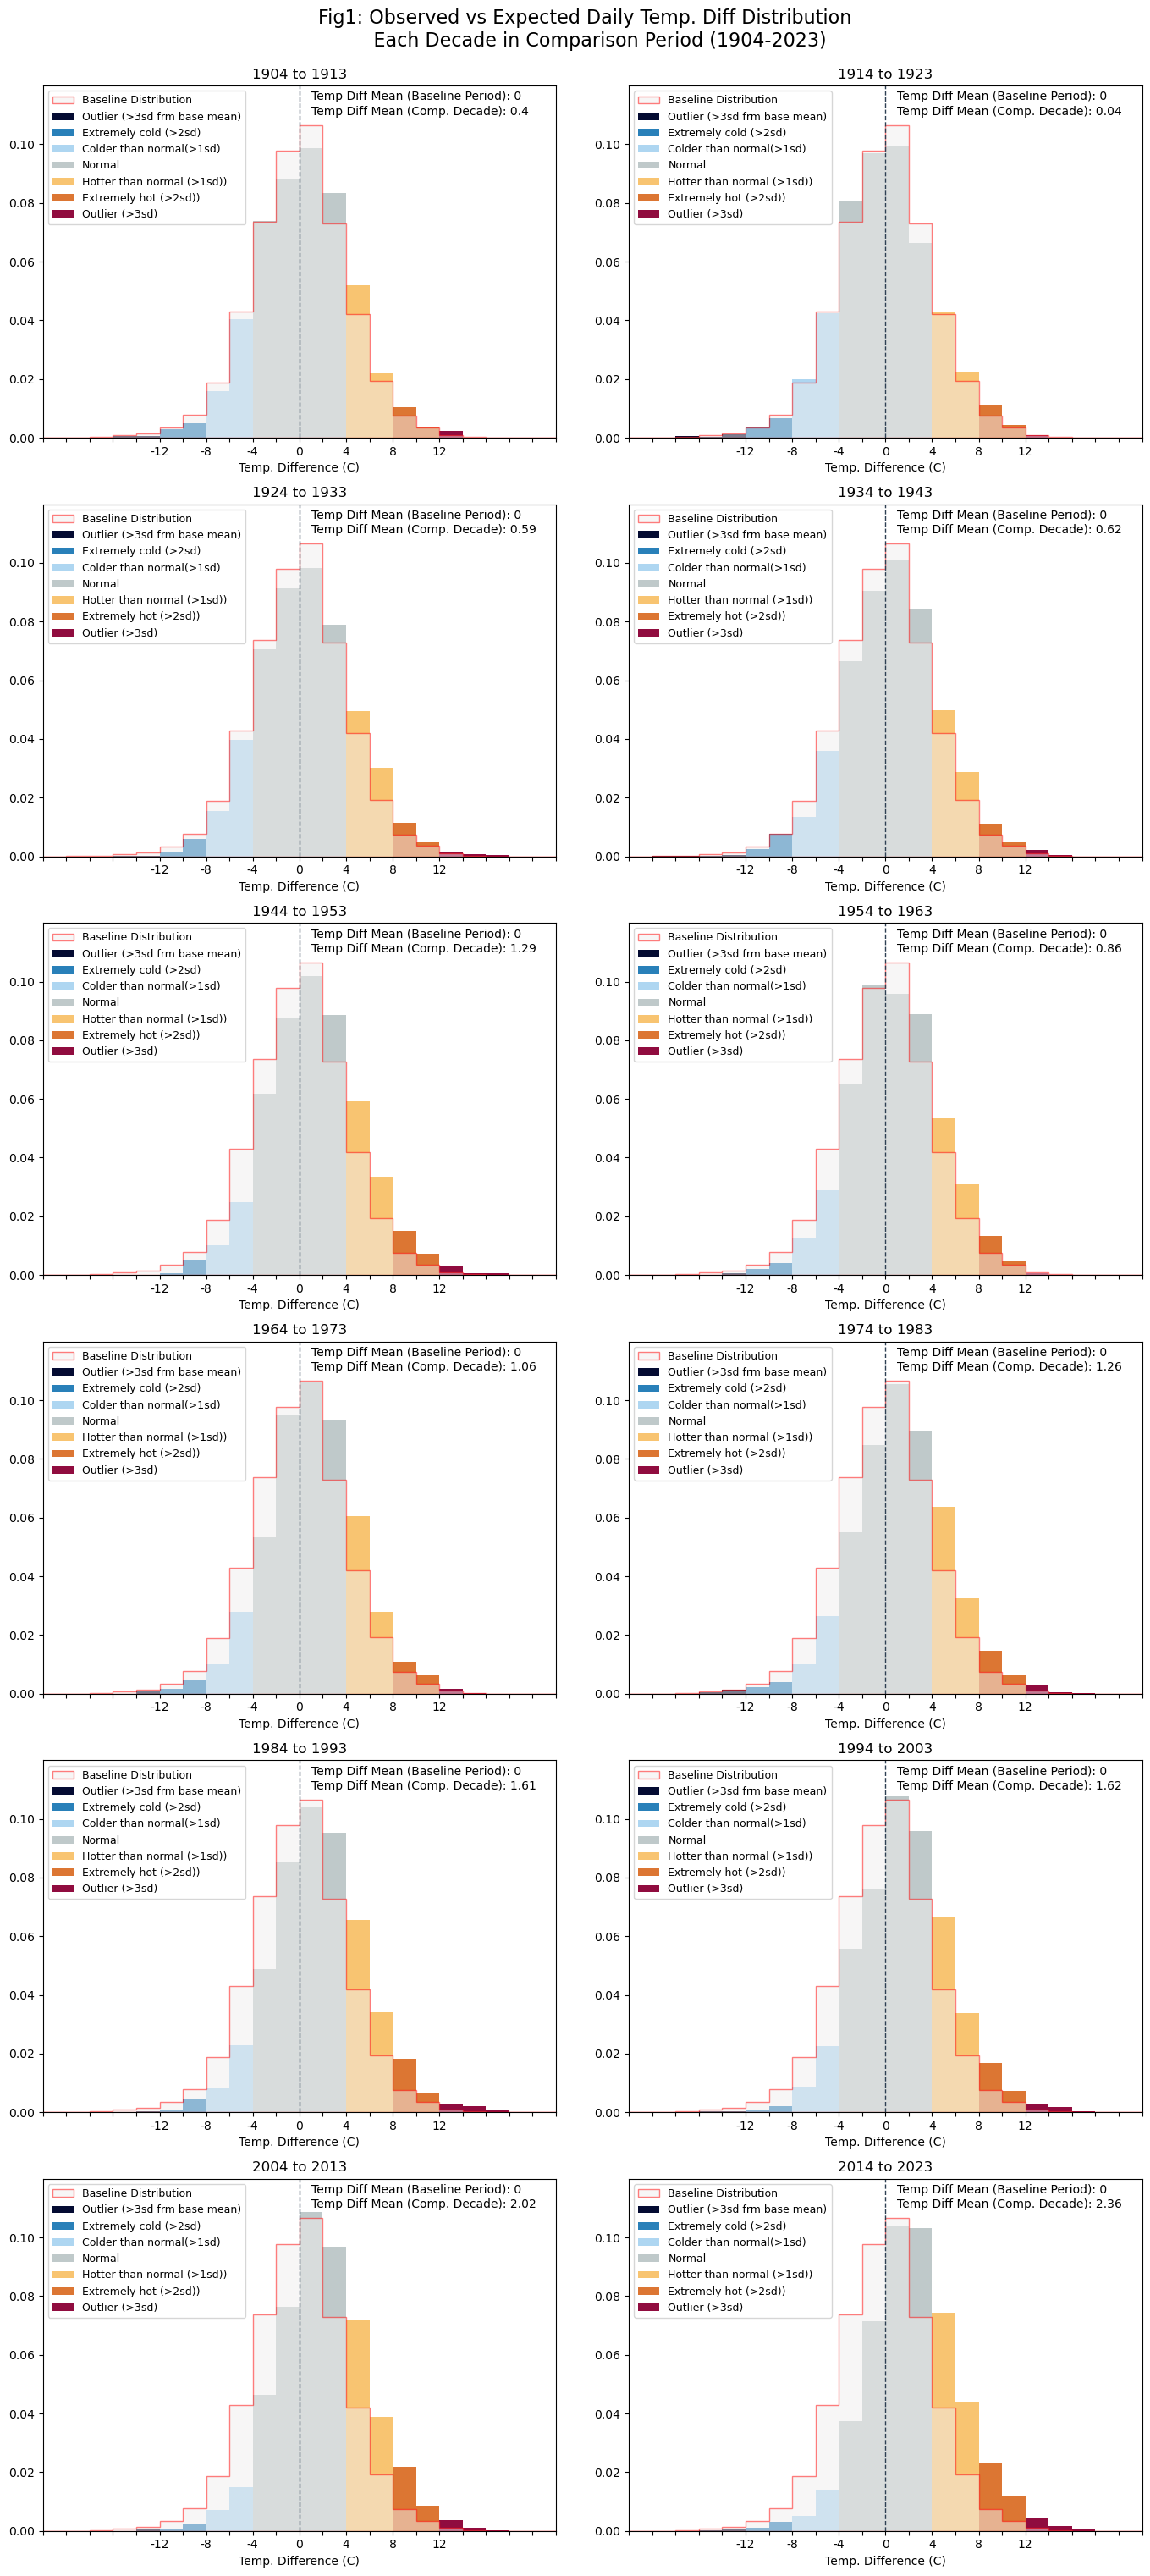

In [10]:
plt.figure(figsize = (14, 31))
plt = create_comparison_hist(plt, comp_df, base_df)
plt.suptitle("""Fig1: Observed vs Expected Daily Temp. Diff Distribution 
    Each Decade in Comparison Period (1904-2023)\n\n""", fontsize = 16);
plt.rcParams['figure.figsize'] = [14,31];
plt.tight_layout();
plt.savefig('1904_2023_ComparisonPeriod_Histograms.png', bbox_inches='tight')

Each subplot within Figure 1 above, shows the <b>distribution of the differences</b> between the observed daily temperature and the expected baseline daily temperature in that decade. Bars on the right of 0 indicate positive difference, i.e., warmer observed temperatures in that decade when compared to the expected baseline daily temperatures. Similarly, the left of 0 would indicate cooler observed daily temperatures in that decade when compared to the baseline expected temperatures.

<b>The key observations:</b>
* For each decade the daily temperature differences against baseline are normally distributed, however, the distributions are moving towards the right, i.e., warmer temperatures on average. 
* In the initial decades of the 20th century, this normal distribution appears to be centered at 0, i.e, mean 0 implying on average, no differences with expected daily temperatures. But as we move through the decades, we see the normal distribution moving more to the right, i.e., more positive differences indicating warmer observed temperatures compared to expected.
* 2011 onwards, the distribution mean is closer to ~2.4 (i.e., on average, temperatures are ~2 times higher than the baseline period
* Over the decades, there is an increase in "extremely large" positive differences, implying significantly warmer temperatures. Further analysis on extreme temperatures is shown in Figure 3.

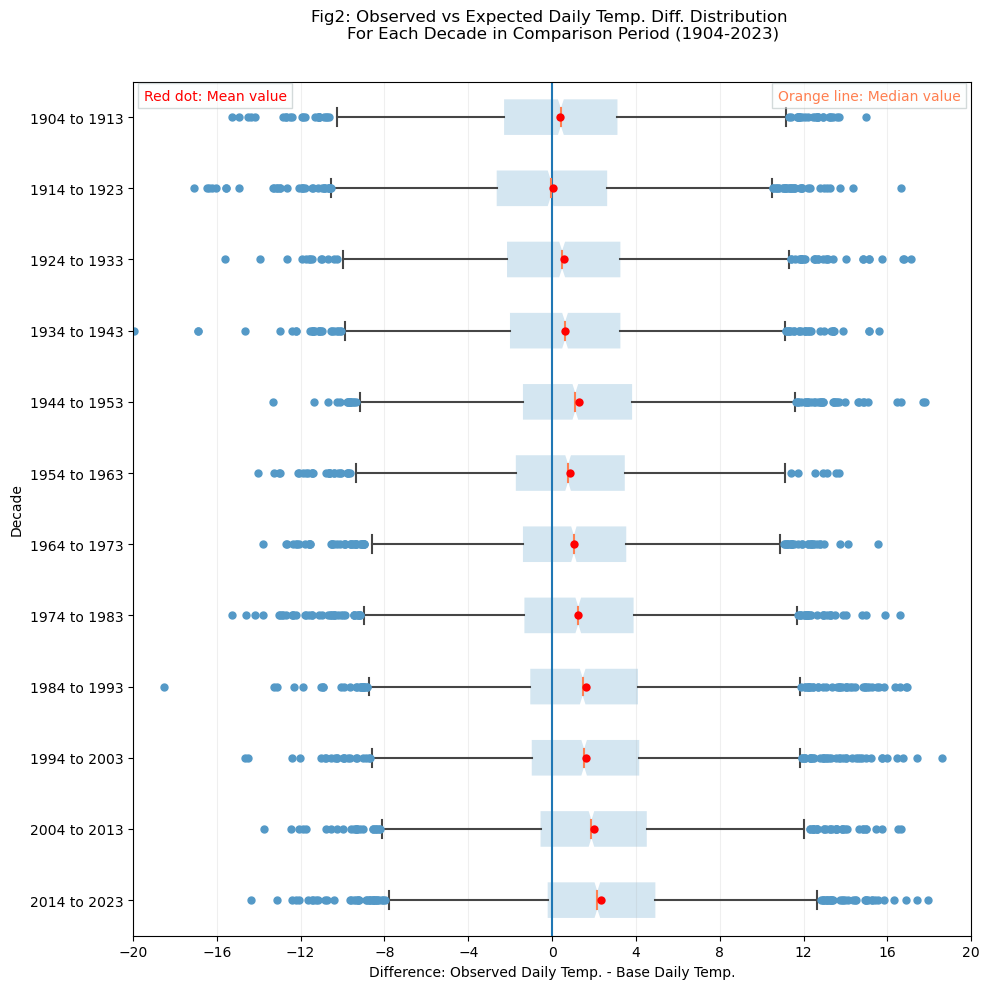

In [11]:
def create_boxplots(comp_df):
    
    plt.figure(figsize = (10,10))
    sns.boxplot(data= comp_df, x = "Diff", y = "Decade", width = 0.5, notch = True, showmeans = True,
                meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"none"}, #,"markersize":"10"},
                boxprops = {"facecolor" : "#D4E6F1", "edgecolor": "none"},
                flierprops = {"marker":"o", "markeredgecolor": "#5499C7","markerfacecolor" : "#5499C7"}, 
                medianprops={"color": "coral"});
    plt.xlabel("Difference: Observed Daily Temp. - Base Daily Temp.")
    plt.grid(axis = "x", alpha = 0.2)

    plt.text(19.5, -0.4, 'Orange line: Median value', color='coral',
            verticalalignment='top', horizontalalignment='right', 
             bbox={'edgecolor':'#AAB7B8', "facecolor": "#FDFEFE",'alpha':0.5,})

    plt.text(-19.5, -0.4, 'Red dot: Mean value', color='red',
            verticalalignment='top', horizontalalignment='left', 
             bbox={'edgecolor':'#AAB7B8', "facecolor": "#FDFEFE",'alpha':0.5,})

    plt.xlim(-20,20)
    plt.gca().set_xticks(np.arange(-20,21,4))
    plt.axvline(0)
    
    return plt

plt = create_boxplots(comp_df)
plt.title("""Fig2: Observed vs Expected Daily Temp. Diff. Distribution 
    For Each Decade in Comparison Period (1904-2023)\n\n""", fontsize = 12);
plt.tight_layout();
plt.savefig("Boxplots_Comparison_with_1870_1903_Baseline.png", bbox_inches='tight')

### <center>Outliers: Record High/Lo Temperatures outside Baseline High/Lo Record Ranges</center>

Temperature readings extracted for each day also include the daily high and low readings. These daily readings from within the baseline period are aggregated to construct a band of possible expected maximum and minimum daily temperatures. For example, the  expected maximum temperature for June 1 would be the maximum temperature from the observed high readings for June 1 from the baseline period. The expected minimum temperature for June 1 is calculated the same way by utilizing the minimum temperature from the observed low readings for June 1 from the baseline period. By utilizing the highest and lowest observed baseline values instead of the median, the broadest range of baseline/expected values is created.

Observed high low daily temperatures for each day in the comparison period are then evaluated against this range with values lying outside this range considered outliers for the purposes of this study. As shown in Figure 2, through the decades, cooler temperature outliers decrease relative to higher temperature outliers.

In [12]:
## OUTLIERS
## comparision daily temps that are outside of record baseline temps

def outliers(df):
    df["Warm_Outlier"] = np.where(df["Record_TMAX"] > df["Base_RecordMax"], df["Record_TMAX"], np.NaN)
    df["Cold_Outlier"] = np.where(df["Record_TMIN"] < df["Base_RecordMin"], df["Record_TMIN"], np.NaN)  
    return df

In [13]:
comp_df = outliers(comp_df)
comp_df[~comp_df["Warm_Outlier"].isnull()][["Decade","MM-DD", "Base_RecordMax","Record_TMAX", "Warm_Outlier"]].head(2)

,Decade,MM-DD,Base_RecordMax,Record_TMAX,Warm_Outlier
85,1904 to 1913,03-26,14.44,18.33,18.33
177,1904 to 1913,06-26,33.33,33.89,33.89


In [14]:
## Baseline record max and record min form the bounds of our range (the widest range we can define). For our comparison 
## periods, we then plot daily temperatures that are significantly different from this range

def plot_outliers(plt, baseline, comp_df):
    i=1

    ##plotting the comparison dataset
    decades = [dec for dec in comp_df["Decade"].unique()]
    for decade in decades:

        _ = comp_df[comp_df["Decade"] == decade]
        plt.subplot(13,1,i)

        ##Baseline record max and record min form the bounds of our range 
        plt.plot(baseline["Base_RecordMin"], lw = 0.9, label = "Baseline Daily Record Min")
        plt.plot(baseline["Base_RecordMax"], lw = 0.9, label = "Baseline Daily Record Max")
        plt.fill_between(baseline.index, baseline["Base_RecordMin"], baseline["Base_RecordMax"], color ="#d8dde6", alpha =0.4);

        ##outliers - record breaking temperatures from the comparison decades
        plt.scatter(_["MM-DD"],_["Warm_Outlier"], color ="red",label =str(_["Warm_Outlier"].count()) + " record breaking warm days");
        plt.scatter(_["MM-DD"],_["Cold_Outlier"], color ="blue",label =str(_["Cold_Outlier"].count()) + " record breaking cold days");   

        plt.gca().set_xticks(np.linspace(0,366,12).round());
        plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);
        plt.ylabel("Temperature (C)");
        plt.legend(loc = "lower center");
        plt.title(decade)
        i += 1 
        
    return plt

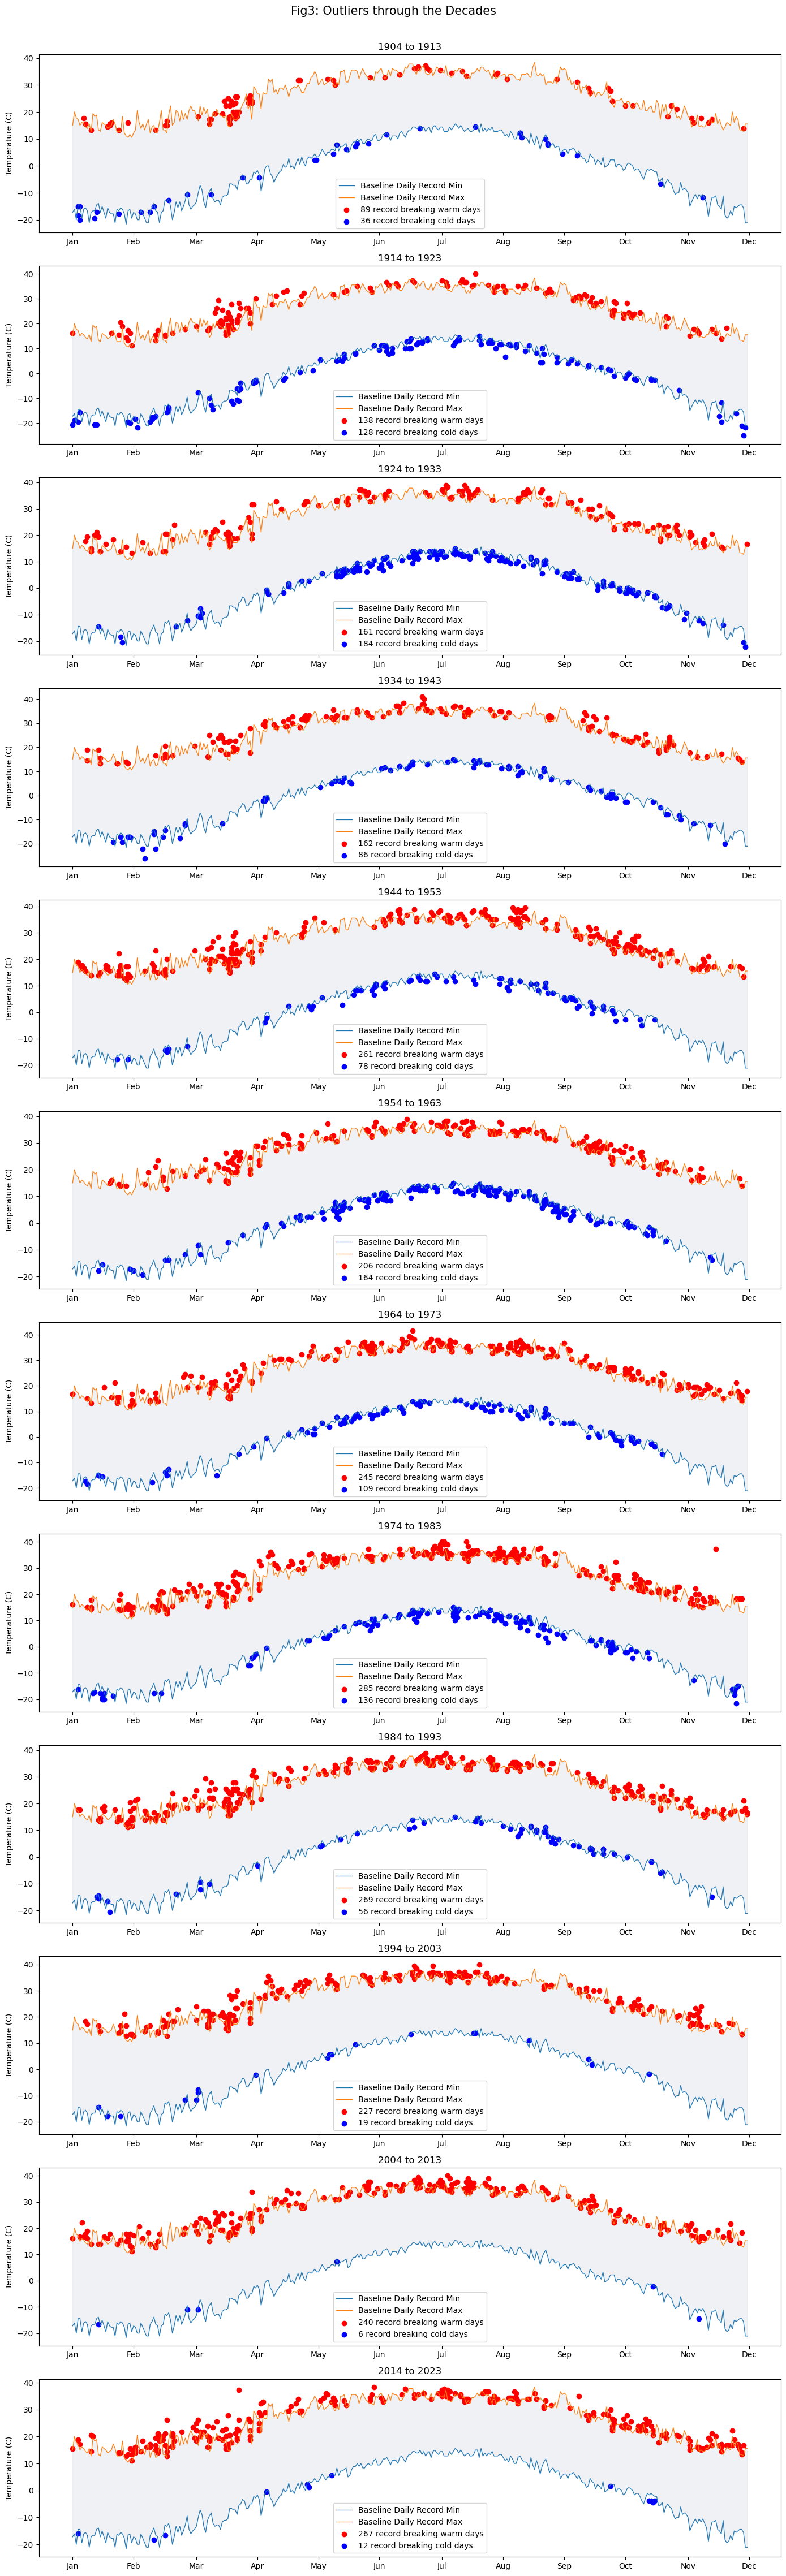

In [15]:
plt.figure(figsize=(14,50)) 
plt = plot_outliers(plt, baseline, comp_df)
plt.suptitle("Fig3: Outliers through the Decades\n\n\n\n\n", fontsize = 15);
plt.rcParams['figure.figsize'] = [14,50];
plt.tight_layout();         
plt.savefig("1904_2023_Outliers.png", bbox_inches='tight')

### <center>Comparisons with a More Recent Baseline Period</center>

In the second part of this study, the baseline period was updated to 1950 to 1983. The motivations for using a more recent baseline are twofold: (1) Analyses that cover "lived" in periods (either directly or via friends and family) maybe easier to connect with as well as invite introspection and discussion, and (2) it is considered to be a period of relatively stable global temperatures as outlined in the aforementioned [paper](https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109) by Dr. Hansen.

However, changing the baseline period does not change the nature of the observations; we still see the distribution moving further to the right decade over decade as shown in Figure 3. Further, the frequency of extremely hot days (>3 std dev. above the mean) is increasing.

In [16]:
##BASELINE DATASET: 1950 - 1980
base_df2 = df[(df["DATE"]>="1950-01-01") & (df["DATE"]<"1984-01-01")] 
baseline2 = create_baseline(base_df2)

base_df2, base_diff_mean2, base_diff_std_dev2 = temperature_differences(base_df2, baseline2, base = "Y")
print(f"For the baseline period, daily temperature differences Distribution mean diff: {base_diff_mean2} and std dev of diff: {base_diff_std_dev2}")
base_df2[["DATE", "Expected_T", "Observed_T", "Diff"]].sample(2)

For the baseline period, daily temperature differences Distribution mean diff: 0 and std dev of diff: 4


,DATE,Expected_T,Observed_T,Diff
7315,1970-01-11,-1.60,-4.17,-2.57
195,1950-07-15,24.86,20.28,-4.58


In [17]:
# plt = create_baseline_hist(base_df2)
# plt.title("""Appendix2: Observed vs Expected Daily Temp. Diff Distribution 
# Baseline Period (1950-1983)""", fontsize = 10);
# plt.tight_layout();
# plt.savefig('1950_1983_Baseline_Temp_Diff.png');

In [18]:
comp_df2 = df[df["DATE"]>="1984-01-01"]
comp_df2 = temperature_differences(comp_df2, baseline2, base = "N")
comp_df2[["Decade", "DATE", "Expected_T", "Observed_T", "Diff"]].sample(2)

,Decade,DATE,Expected_T,Observed_T,Diff
3277,1984 to 1993,1992-12-21,0.62,0.56,-0.06
11889,2014 to 2023,2016-07-20,24.51,24.72,0.21


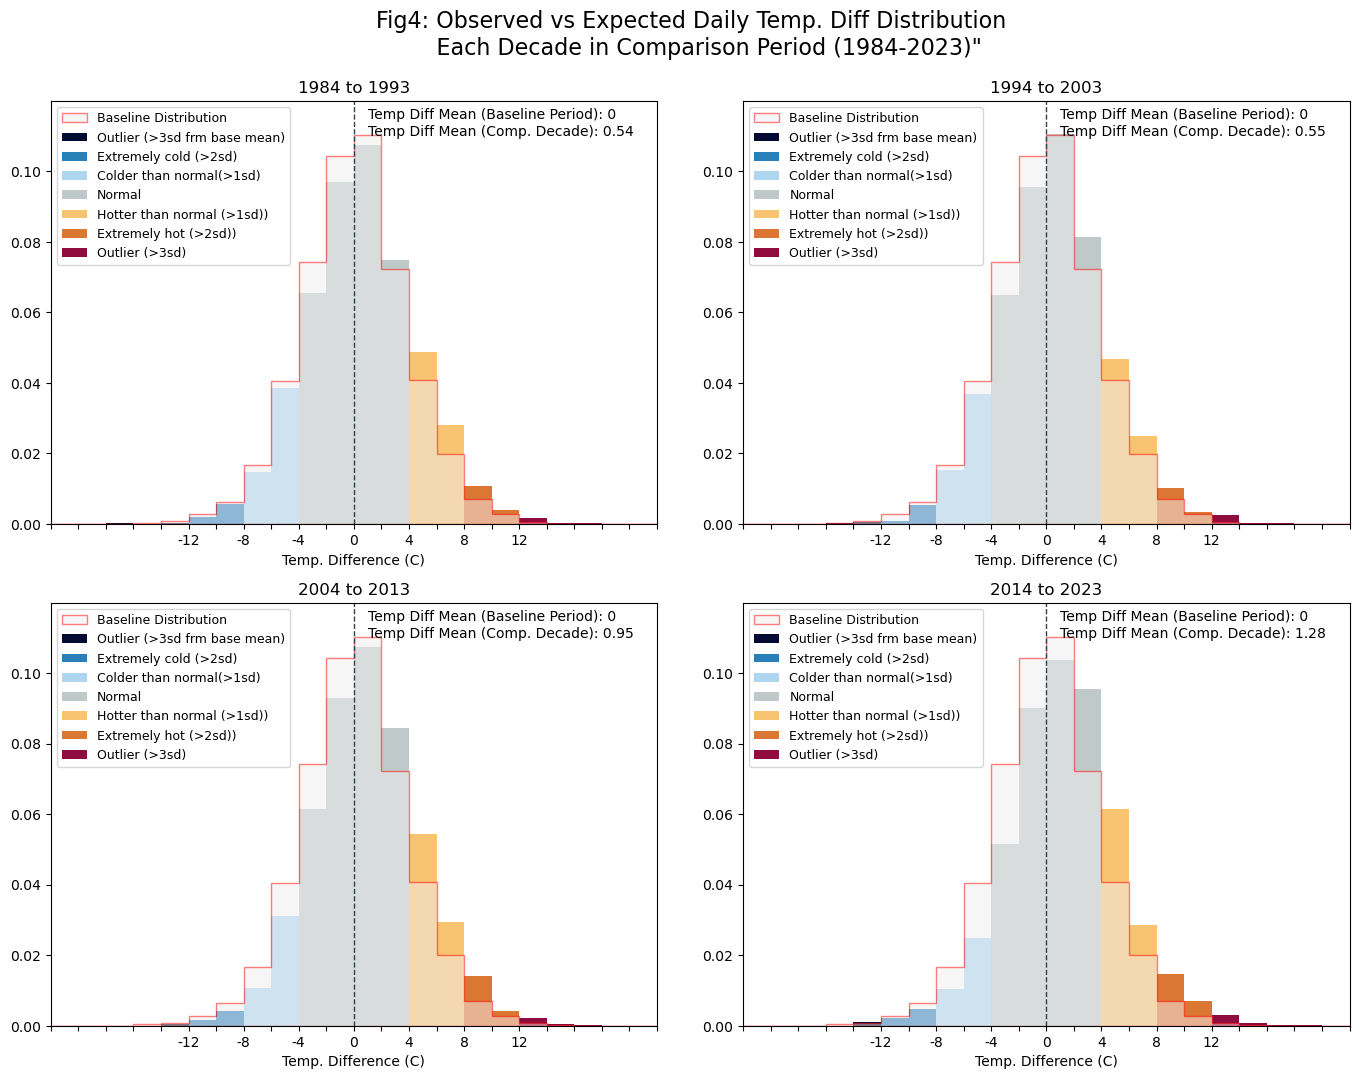

In [19]:
plt.figure(figsize =  (14, 31))
plt = create_comparison_hist(plt, comp_df2, base_df2)
plt.suptitle("""Fig4: Observed vs Expected Daily Temp. Diff Distribution 
    Each Decade in Comparison Period (1984-2023)"\n\n""", fontsize = 16);
plt.tight_layout();
plt.savefig('1984_2023_ComparisonPeriod_Histograms.png', bbox_inches='tight')

In [20]:
# comp_df2 = outliers(comp_df2)
# comp_df2[~comp_df2["Warm_Outlier"].isnull()][["Decade","MM-DD", "Base_RecordMax","Record_TMAX", "Warm_Outlier"]].sample(2)

In [21]:
# plt.figure(figsize = (14,60))
# plt = plot_outliers(plt, baseline2, comp_df2)
# plt.suptitle("Fig5: Outliers through the Decades\n\n\n\n\n", fontsize = 15);
# plt.tight_layout();         
# # plt.savefig("1984_2023_Outliers.png")

In [22]:
## OUTLIERS - Approach 2: Comparing the observed temperature from the comparison period to the record temperatures 
## in the baseline periods to assess if we have any outliers outside the largest/smallest values seen in the baseline period
# ## comparision daily temps that are outside of record baseline temps
# comp_df["Outlier"] = np.where(comp_df.Observed_T>comp_df.Base_RecordMax, 
#                               comp_df.Observed_T,
#                               np.where(comp_df.Observed_T<comp_df.Base_RecordMin, 
#                                        comp_df.Observed_T,
#                                        np.NaN))
# comp_df[~comp_df["Outlier"].isnull()][["Decade","MM-DD", "Base_RecordMax","Base_RecordMin","Outlier"]].head(2)



##Visualization did not yield meaningful results
# plt.figure(figsize=(14,60))
# i=1
    
# ##plotting the comparison dataset
# decades = [dec for dec in comp_df["Decade"].unique()]
# for decade in decades:
    
#     plt.subplot(13,1,i)

#     ##Baseline record max and record min form the bounds of our range 
#     plt.plot(baseline["Base_RecordMin"], lw = 0.9, label = "Baseline Daily Record Min")
#     plt.plot(baseline["Base_RecordMax"], lw = 0.9, label = "Baseline Daily Record Max")
#     plt.fill_between(baseline.index, baseline["Base_RecordMin"], baseline["Base_RecordMax"], color ="#d8dde6", alpha =0.4);

#     ##outliers - record breaking temperatures from the comparison decades
#     _ = comp_df[(comp_df["Decade"] == decade) & (comp_df["Outlier"] >0)]
#     plt.scatter(_["MM-DD"],_["Outlier"], color ="red",label = str(_["Outlier"].count()) + " record breaking warm days");
#     _ = comp_df[(comp_df["Decade"] == decade) & (comp_df["Outlier"] <0)]
#     plt.scatter(_["MM-DD"],_["Outlier"], color ="blue",label =str(_["Outlier"].count()) + " record breaking cold days");   
    
#     plt.gca().set_xticks(np.linspace(0,366,12).round());
#     plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);
#     plt.ylabel("Temperature (C)");
#     plt.legend(loc = "lower center");
#     plt.title(decade)
#     i += 1 

# plt.suptitle("Fig4: Outliers through the Decades\n\n\n\n\n", fontsize = 15);
# plt.tight_layout();         
# # plt.savefig("Outliers.png")

#### Reference Papers:

https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109

https://www.climate-lab-book.ac.uk/2016/how-to-quantify-changes-in-climate-extremes-without-inducing-artefacts/

https://www.nytimes.com/interactive/2018/05/03/learning/08WGOITGraphLN.html

https://www.nytimes.com/interactive/2021/climate/extreme-summer-heat.html

https://public.wmo.int/en/our-mandate/climate/wmo-statement-state-of-global-climate